In [1]:
import shrimpy
# Import libraries and dependencies
import numpy as np
import pandas as pd
import os

from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import alpaca_trade_api as tradeapi
from pathlib import Path
from dotenv import load_dotenv
%matplotlib inline

In [2]:
# Set environment variables from the .env file
env_path = Path("/Users/GrantDePalma")/'.env'
load_dotenv(env_path)

shrimpy_public_key = os.getenv("SHRIMPY_PUBLIC_KEY")
shrimpy_private_key = os.getenv("SHRIMPY_PRIVATE_KEY")

client = shrimpy.ShrimpyApiClient(shrimpy_public_key, shrimpy_private_key)

In [64]:
def execute_backtest(initial_capital, exchange,rebalance_freq,starttime, endtime, fee_perc):
    backtest_results = client.run_backtest(exchange, rebalance_freq, fee_perc,starttime,endtime, initial_capital, 
                                      [
                                          {'symbol':"XBT", 'percent': '50'},
                                          {'symbol': "ETH", 'percent': '50'}
                                      ])
    backtest_results_df = pd.DataFrame(columns=['time', 'usdValue'])
    results = backtest_results['holdingData']
    for index, value in enumerate(results):
        #print(value)
        backtest_results_df.loc[index] = [(value['time']), value['usdValue']]

    backtest_results_df['time'] = pd.to_datetime(backtest_results_df['time'])
    backtest_results_df['time'] = backtest_results_df['time'].dt.round('D')
    
    candles_df = pd.DataFrame(columns=['time', 'btcusd'])
    candles = client.get_candles('kraken','xbt', 'usd', '1d',starttime)
    for key, value in enumerate(candles):
        candles_df.loc[key] = [pd.to_datetime(value['time']), value['close']]
    candles_df['time'] = pd.to_datetime(candles_df['time'])
    
    backtest_results_df0 = pd.merge(candles_df,backtest_results_df, on='time', how='left')
    backtest_results_df0 = backtest_results_df0.set_index('time')
    backtest_results_df0 = backtest_results_df0.apply(pd.to_numeric)
    
    backtest_results_df0['btcusd_change'] = backtest_results_df0['btcusd'].pct_change()
    backtest_results_df0['btcusd_cum_returns'] =(1+ backtest_results_df0['btcusd_change']).cumprod()
    backtest_results_df0['btcValue'] = backtest_results_df0['usdValue']/backtest_results_df0['btcusd']
    backtest_results_df0['btc_perc_change'] = backtest_results_df0['btcValue'].pct_change()
    backtest_results_df0['usd_perc_change'] = backtest_results_df0['usdValue'].pct_change()
    backtest_results_df0['usd_cum_returns'] = (1+ backtest_results_df0['usd_perc_change']).cumprod()
    backtest_results_df0['btc_cum_returns'] = (1+ backtest_results_df0['btc_perc_change']).cumprod()
    backtest_results_df1 = backtest_results_df0.dropna()
    backtest_results_df1['alpha'] = backtest_results_df1['usd_cum_returns'] - backtest_results_df1['btcusd_cum_returns']
    backtest_results_df1['usd_rolling_returns_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    backtest_results_df1['btc_rolling_returns_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    backtest_results_df1['usd_rolling_vol_wk'] = backtest_results_df1['usd_perc_change'].rolling(7).std()
    backtest_results_df1['btc_rolling_vol_wk'] = backtest_results_df1['btc_perc_change'].rolling(7).std()
    backtest_results_df1['usd_rolling_returns_mo'] = backtest_results_df1['usd_perc_change'].rolling(7).sum()
    backtest_results_df1['btc_rolling_returns_mo'] = backtest_results_df1['btc_perc_change'].rolling(7).sum()
    backtest_results_df1['usd_rolling_vol_mo'] = backtest_results_df1['usd_perc_change'].rolling(30).std()
    backtest_results_df1['btc_rolling_vol_mo'] = backtest_results_df1['btc_perc_change'].rolling(30).std()
    
    backtest_results_df1['usd_rolling_sharpe_wk'] = backtest_results_df1['usd_rolling_returns_wk']/backtest_results_df1['usd_rolling_vol_wk']
    backtest_results_df1['btc_rolling_sharpe_wk'] = backtest_results_df1['btc_rolling_returns_wk']/backtest_results_df1['btc_rolling_vol_wk']
    backtest_results_df1['usd_rolling_sharpe_mo'] = backtest_results_df1['usd_rolling_returns_mo']/backtest_results_df1['usd_rolling_vol_mo']
    backtest_results_df1['btc_rolling_sharpe_mo'] = backtest_results_df1['btc_rolling_returns_mo']/backtest_results_df1['btc_rolling_vol_mo']
    
# More Risk Measures
    # Max Drawdown 
    # Skewness
    # Kurtosis
    # VAR
    # CVAR
    
    
    
    # Calc Static Portfolio Evaluation Metrics
    usd_metrics= [
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    btc_metrics = [
        
        'initial_capital',
        'cumulative_returns',
        'annualized_returns',
        'mthly_returns',
        'annual_vol',
        'mthly_vol',
        'annual_sharpe',
        'mthly_sharpe',
        'annual_sortino',
        'mthly_sortino',
    ]
    
    columns = ['Backtest']
    
    port_eval_df_usd = pd.DataFrame(index=usd_metrics, columns=columns)
    
    port_eval_df_usd.loc['initial_capital'] = backtest_results_df0['usdValue'].iloc[0]
    port_eval_df_usd.loc['cumulative_returns'] = backtest_results_df1['usd_cum_returns'].iloc[-1]
    port_eval_df_usd.loc['annualized_returns'] = backtest_results_df1['usd_perc_change'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_returns'] = backtest_results_df1['usd_perc_change'].mean() *30
    port_eval_df_usd.loc['annual_vol'] = backtest_results_df1['usd_perc_change'].std() * np.sqrt(365)  #Crypto trades 365 days per year
    port_eval_df_usd.loc['mthly_vol'] = backtest_results_df1['usd_perc_change'].std() * np.sqrt(30)
    port_eval_df_usd.loc['annual_sharpe'] = port_eval_df_usd.loc['annualized_returns']/port_eval_df_usd.loc['annual_vol']
    port_eval_df_usd.loc['mthly_sharpe'] = port_eval_df_usd.loc['mthly_returns']/port_eval_df_usd.loc['mthly_vol']
        
    
    port_eval_df_btc = pd.DataFrame(index=btc_metrics, columns=columns)
    port_eval_df_btc.loc['initial_capital'] = backtest_results_df0['btcValue'].iloc[0]
    port_eval_df_btc.loc['cumulative_returns'] = backtest_results_df1['btc_cum_returns'].iloc[-1]
    port_eval_df_btc.loc['annualized_returns'] = backtest_results_df1['btc_perc_change'].mean() *365  #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_returns'] = backtest_results_df1['btc_perc_change'].mean() *30
    port_eval_df_btc.loc['annual_vol'] = backtest_results_df1['btc_perc_change'].mean() * np.sqrt(365) #Crypto trades 365 days per year
    port_eval_df_btc.loc['mthly_vol'] = backtest_results_df1['btc_perc_change'].mean() * np.sqrt(30)
    port_eval_df_btc.loc['annual_sharpe'] = port_eval_df_btc.loc['annualized_returns']/port_eval_df_btc.loc['annual_vol']
    port_eval_df_btc.loc['mthly_sharpe'] = port_eval_df_btc.loc['mthly_returns']/port_eval_df_btc.loc['mthly_vol']
    
    # Calculate Sortino Ratios
    sortino_ratio_df = backtest_results_df1[['usd_perc_change','btc_perc_change']].copy()
    sortino_ratio_df.loc[:, "downside_usd"] = 0
    sortino_ratio_df.loc[:,"downside_btc"] = 0
    target = 0
    mask_usd = sortino_ratio_df['usd_perc_change'] < target
    mask_btc = sortino_ratio_df['btc_perc_change'] < target
    
    sortino_ratio_df.loc[mask_usd, "downside_usd"] = (sortino_ratio_df["usd_perc_change"]**2)
    sortino_ratio_df.loc[mask_btc, "downside_btc"] = (sortino_ratio_df["btc_perc_change"]**2)
    
    down_stdev_usd_annual = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(365)
    down_stdev_btc_annual = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(365)
    down_stdev_btc_mthly = np.sqrt(sortino_ratio_df['downside_btc'].mean()) * np.sqrt(30)
    down_stdev_usd_mthly = np.sqrt(sortino_ratio_df['downside_usd'].mean()) * np.sqrt(30)
    
    expected_return_usd_annual = sortino_ratio_df['usd_perc_change'].mean()*365
    expected_return_btc_annual = sortino_ratio_df['btc_perc_change'].mean()*365
    sortino_ratio_usd_annual = expected_return_usd_annual/down_stdev_usd_annual
    sortino_ratio_btc_annual = expected_return_btc_annual/down_stdev_btc_annual
    
    expected_return_usd_mthly = sortino_ratio_df['usd_perc_change'].mean()*30
    expected_return_btc_mthly = sortino_ratio_df['btc_perc_change'].mean()*30
    
    sortino_ratio_usd_mthly = expected_return_usd_mthly/down_stdev_usd_mthly
    sortino_ratio_btc_mthly = expected_return_btc_mthly/down_stdev_btc_mthly
    
    port_eval_df_usd.loc['annual_sortino'] = sortino_ratio_usd_annual
    port_eval_df_usd.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    port_eval_df_btc.loc['annual_sortino'] = sortino_ratio_btc_annual
    port_eval_df_btc.loc['mthly_sortino'] = sortino_ratio_usd_mthly
    
    return backtest_results_df1, port_eval_df_usd, port_eval_df_btc


In [65]:
backtest_df, port_eval_df_usd, port_eval_df_btc = execute_backtest(100000, 'kraken',1, '2018-05-19T00:00:00.000Z', '2020-08-14T00:00:00.000Z', 0.1)

C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas

In [66]:
backtest_df.tail()

,btcusd,usdValue,btcusd_change,btcusd_cum_returns,btcValue,btc_perc_change,usd_perc_change,usd_cum_returns,btc_cum_returns,alpha,...,usd_rolling_vol_wk,btc_rolling_vol_wk,usd_rolling_returns_mo,btc_rolling_returns_mo,usd_rolling_vol_mo,btc_rolling_vol_mo,usd_rolling_sharpe_wk,btc_rolling_sharpe_wk,usd_rolling_sharpe_mo,btc_rolling_sharpe_mo
time,,,,,,,,,,,,,,,,,,,,,
2020-08-10 00:00:00+00:00,11898.7,98860.057348,0.018071,1.445104,8.308475,-0.024490,-0.006862,0.988601,0.684103,-0.456504,...,0.020884,0.033614,0.049565,-0.005671,0.026846,0.041930,2.373376,-0.168695,1.846317,-0.135237
2020-08-11 00:00:00+00:00,11391.7,100620.977139,-0.042610,1.383529,8.832832,0.063111,0.017812,1.006210,0.727278,-0.377319,...,0.020612,0.040874,0.046817,0.033253,0.026691,0.043258,2.271328,0.813551,1.754085,0.768715
2020-08-12 00:00:00+00:00,11576.6,96684.890748,0.016231,1.405985,8.351752,-0.054465,-0.039118,0.966849,0.687667,-0.439136,...,0.027034,0.042834,0.006287,0.024138,0.028202,0.044550,0.232555,0.563522,0.222921,0.541821
2020-08-13 00:00:00+00:00,11794.6,98338.925643,0.018831,1.432461,8.337623,-0.001692,0.017107,0.983389,0.686503,-0.449072,...,0.022374,0.039997,-0.017076,-0.015771,0.028088,0.044519,-0.763214,-0.394294,-0.607953,-0.354246
2020-08-14 00:00:00+00:00,11772.6,102091.159721,-0.001865,1.429789,8.671930,0.040096,0.038156,1.020912,0.714029,-0.408878,...,0.027104,0.042991,0.024196,0.013009,0.028520,0.045025,0.892708,0.302593,0.848407,0.288928


In [68]:
port_eval_df_usd

,Backtest
initial_capital,100000
cumulative_returns,1.02091
annualized_returns,0.326605
mthly_returns,0.0268443
annual_vol,0.780398
mthly_vol,0.223733
annual_sharpe,0.418511
mthly_sharpe,0.119984
annual_sortino,0.579262
mthly_sortino,0.166069


### Portfolio Performance Dashboard
    1. Input Variables
    2. Run Backtest
    3. Evaluate Static Performance Statistics
        - performance measured in usd
        - performance measured in btc
    4. Visualize Risk Adjusted Performance over time
        - Reward
            - Daily Returns
            - Cumulative Returns
            - Rolling Returns
            - Alpha
        - Risk
            - box plots
            - rolling vol
            - rolling sharpe
    
---

#### 1. Input Variables

In [13]:
initial_capital = 100000
exchange = 'kraken'
rebalance_freq = 1
start = '2018-05-19T00:00:00.000Z'
end = '2020-08-14T00:00:00.000Z'
perc_fee = 0.1

#### 2. Run Backtest

In [14]:
backtest_df, port_eval_df = execute_backtest(initial_capital, exchange,rebalance_freq,start,end, perc_fee)

#### 4. Evaluate Static Performance Stats

In [90]:
port_eval_df_usd

,Backtest
initial_capital,100000
cumulative_returns,1.02091
annualized_returns,0.326605
mthly_returns,0.0268443
annual_vol,0.780398
mthly_vol,0.223733
annual_sharpe,0.418511
mthly_sharpe,0.119984
annual_sortino,0.579262
mthly_sortino,0.166069


In [89]:
port_eval_df_btc

,Backtest
initial_capital,12.1451
cumulative_returns,0.714029
annualized_returns,0.531875
mthly_returns,0.0437157
annual_vol,0.0278396
mthly_vol,0.00798136
annual_sharpe,19.105
mthly_sharpe,5.47723
annual_sortino,0.684793
mthly_sortino,0.166069


#### 3. Performance Visualizations

C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4528B4B08>,
      dtype=object)

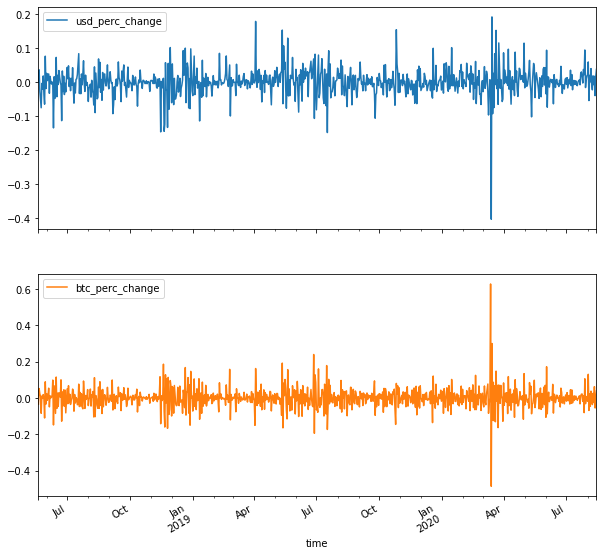

In [80]:
## Returns
backtest_df[['usd_perc_change', 'btc_perc_change']].plot(subplots=True, figsize = [10,10])

C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A4529AA3C8>,
      dtype=object)

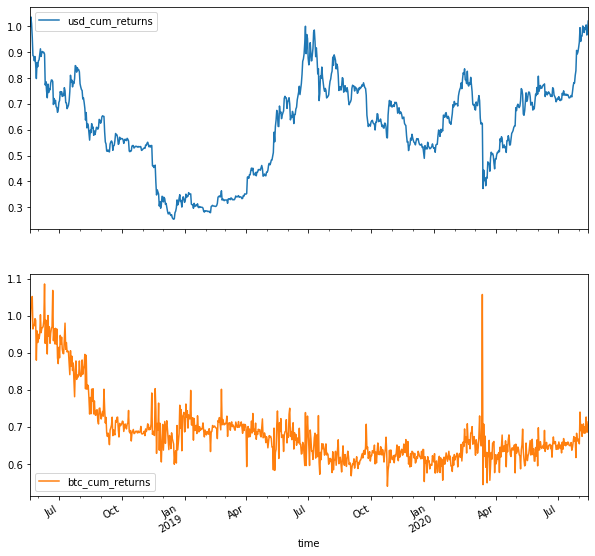

In [81]:
## Cum Returns
backtest_df[['usd_cum_returns', 'btc_cum_returns']].plot(subplots=True, figsize = [10,10])

C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A452F27248>,
      dtype=object)

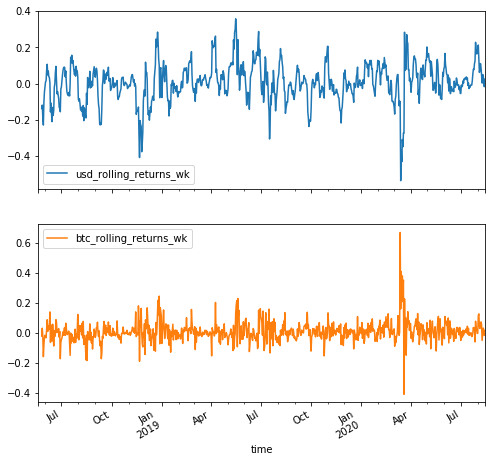

In [86]:
## USD Rolling Returns
backtest_df[['usd_rolling_returns_wk', 'btc_rolling_returns_wk']].plot(subplots=True, figsize=[8,8])

C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)
C:\Users\GrantDePalma\Anaconda3_new\lib\site-packages\pandas\core\arrays\datetimes.py:1172: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  "will drop timezone information.", UserWarning)


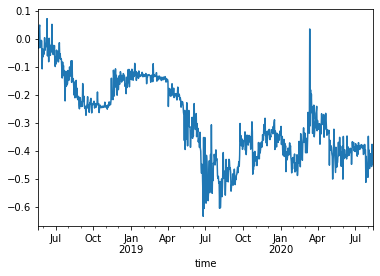

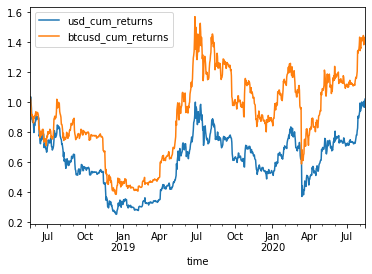

In [88]:
# Alpha (usd returns - btcusd returns)
backtest_df['alpha'].plot()
backtest_df[['usd_cum_returns', 'btcusd_cum_returns']].plot()

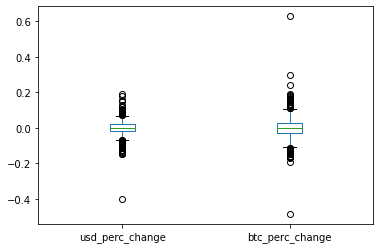

In [16]:
## Box Plot
backtest_df[['usd_perc_change', 'btc_perc_change']].plot.box()

In [ ]:
## 

# Data Visualizations
Stats
- Total Account Value
- Capital at Risk: [BTC, %], [USD, %]
- Expected Accumulation: [ BTC, % ], [USD,%]
- Current Accuumulation: [ BTC, % ], [USD,%]
- Algorithm Sortino Ratio: 

REAL TIME / BACKTEST Viz
- (Multi and single account) Timeseries
    - BTC Accumulation relative to expected return
    - Bucket Allocation Weights relative to thresholds
    - ALT Asset Allocation weights relative to thresholds
 
- (Multi and single account) Pie charts
    - Bucket Allocation weights relative to thresholds
    - ALT Asset Allocation weights relative to thresholds

- (Multi and Single account) Radial
    - btc accumulation rate
    - bucket accumulation rates
    - ALT Asset Accumulation rates
    
- REAL TIME MONITORS
    - Shrimpy Dashboard
    - TradingView Charts
    - Performance Viz 1
    - Performance Viz 2
    
- FLOW DIAGRAMS
    - CoinFlows

